In [1]:
import numpy as np
import random
from keras import callbacks
from keras.callbacks import History
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, concatenate
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
import string
from typing import List, Tuple
import re

random.seed(10)
np.random.seed(10)

In [2]:
import pandas as pd
from pandas import DataFrame


def load_lyrics(csv_path: str) -> DataFrame:
    df = pd.read_csv(csv_path, sep='\n', header=None)
    # res = df.iloc[:, 0].str.rstrip(r'&, ').str.extract(r'([^,]+),([^,]+),(.+)')
    res = df.iloc[:, 0].str.extract(r'([^,]+),([^,]+),(.+)')
    res.columns = ['artist', 'title', 'lyrics']
    return res

def load_songs(path) -> List[str]:
    df = load_lyrics(path)
    for i, song in enumerate(list(df['lyrics'])):

        song += " EOF"
        # remove '(*)'
        modified_song = re.sub(r"\([^()]*\)", "", song)
        modified_song = modified_song.replace("chorus", "").replace('&', '\n').lower()
        regex = re.compile('[%s]' % re.escape(string.punctuation))
        modified_song = regex.sub('', modified_song)
        df.loc[i, 'lyrics'] = modified_song
    return df

In [3]:
def create_x_y(songs, tokenize, total_words, max_len) -> Tuple[np.ndarray, np.ndarray]:
    input_sequences = []
    midi_meta = []
    for index, row in songs.iterrows():
      line = row['lyrics']
    # for line in songs:
      token_list = tokenize.texts_to_sequences([line])[0]
      midi_metadata = row.drop(['artist', 'title', 'lyrics', 'filename']).values
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i + 1]
          input_sequences.append(n_gram_sequence)
          midi_meta.append(midi_metadata)
    print(input_sequences[:10])
    # max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
    x = input_sequences[:, :-1]
    x_midi = np.array(midi_meta)
    y = input_sequences[:, -1]
    y = utils.to_categorical(y, num_classes=total_words)
    return x, x_midi, y #, max_sequence_len

def split_df_to_train_val(df, ratio):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_val = df[~mask]
    return df_train, df_val

In [4]:
class LyricsGenerator(object):

    def __init__(self, embedding_dim: int, vocab_size: int, input_size: int, midi_features_size: int, embedding_matrix: np.ndarray):
        input_lyrics = Input(shape=(input_size,))
        embedding_layer = Embedding(
            vocab_size,
            embedding_dim,
            input_length=input_size,
            weights=[embedding_matrix],
            # embeddings_initializer=initializers.Constant(embedding_matrix),
            trainable=True,
        )(input_lyrics)
        lstm = LSTM(units=embedding_dim)(embedding_layer)
        lyrics_model = Dropout(0.2)(lstm)

        input_midi =  Input(shape=(midi_features_size,))
        midi_model = Dense(50, activation='relu')(input_midi)
        midi_model = Dense(10, activation='relu')(midi_model)

        final_model_1 = concatenate([lyrics_model, midi_model])
        final_model = Dense(units=vocab_size, activation='softmax')(final_model_1)
        self.model = Model(inputs=[input_lyrics, input_midi], outputs=final_model)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()

    def fit(self, x, y, hyper_parameters):
        callback = callbacks.EarlyStopping(monitor='loss', patience=3)
        callback2 = callbacks.LearningRateScheduler(self._lr_scheduler)
        # callback3 = callbacks.ModelCheckpoint('lyrics_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        # callback = callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1)
        # history = self.model.fit(x, y, epochs=100, verbose=1)
        history = self.model.fit(x, y, batch_size=hyper_parameters['batch_size'], epochs=hyper_parameters['epochs'],
                                 callbacks=[callback],
                                 # callbacks=[callback, callback2],
                                 verbose=1, validation_split=hyper_parameters['validation_split'],
                                 validation_data=hyper_parameters['val_data'])
        self.model.save('lyrics_model.h5')
        
        return history

    def _lr_scheduler(self, epoch, lr):
        return 0.95 * lr

    def evaluate(self, x, y):
        predictions = self.model.evaluate(x, y)
        return predictions

    # to get a picture of loss progress.
    def plot_metric(self, history: History, metric: str = 'loss') -> None:
        import matplotlib.pyplot as plt
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])
        plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
df_songs = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_train_set.csv')

In [7]:
df_songs['lyrics'][0]

'goodbye norma jean \n though i never knew you at all \n you had the grace to hold yourself \n while those around you crawled \n they crawled out of the woodwork \n and they whispered into your brain \n they set you on the treadmill \n and they made you change your name \n and it seems to me you lived your life \n like a candle in the wind \n never knowing who to cling to \n when the rain set in \n and i would liked to have known you \n but i was just a kid \n your candle burned out long before \n your legend ever did \n loneliness was tough \n the toughest role you ever played \n hollywood created a superstar \n and pain was the price you paid \n even when you died \n oh the press still hounded you \n all the papers had to say \n was that marilyn was found in the nude \n and it seems to me you lived your life \n like a candle in the wind \n never knowing who to cling to \n when the rain set in \n and i would liked to have known you \n but i was just a kid \n your candle burned out lon

In [8]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/midi_files.zip',"r") as zip_ref:
  zip_ref.extractall("temp_dir")

In [9]:
!pip install mido

     |████████████████████████████████| 51kB 4.7MB/s 


In [8]:
from os import listdir
from mido import MidiFile
from mido.midifiles.meta import KeySignatureError

files_in_dir = [f for f in listdir("temp_dir/midi_files") if re.match('.*\.mid', f)]
df_midi = pd.DataFrame(columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])

def parse(file,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo):
  mid = MidiFile(file, clip=True)
  # for track in mid.tracks:
      # print(track)
  for msg in mid.tracks[0]:
    # print(msg.dict())
    if msg.dict()['type'] == 'key_signature':
      mode = 'minor' if msg.dict()['key'][-1] == 'm' else 'major'
      key = msg.dict()['key'] if mode == 'major' else msg.dict()['key'][:-1]
    if msg.dict()['type'] == 'set_tempo':
      tempo = msg.dict()['tempo']/1000
    if msg.dict()['type'] == 'time_signature':
      numerator = msg.dict()['numerator']
      denominator = msg.dict()['denominator']
      clocksPerTick = msg.dict()['clocks_per_click']
      demisemiquaverPer24Clocks = msg.dict()['notated_32nd_notes_per_beat']
  return numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo

for i, f in enumerate(files_in_dir):
  numerator = denominator = clocksPerTick = demisemiquaverPer24Clocks = -1
  key = mode = 'unknown'
  tempo = -1
  try:
    numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo = parse("temp_dir/midi_files/" + f,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo)
  except (UnicodeDecodeError, KeySignatureError, EOFError) as e:
    continue

  print(f'{numerator},{denominator},{clocksPerTick},{demisemiquaverPer24Clocks},{key},{mode},{tempo}')
  df_tmp = pd.DataFrame([[f.lower(),numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo ]], columns=['filename', 'numerator', 'denominator', 'clocksPerTick', 'demisemiquaverPer24Clocks', 'key', 'mode', 'tempo'])
  df_midi= pd.concat([df_midi, df_tmp])
# print(f'{numerator},{denominator},{clocksPerTick},{demisemiquaverPer24Clocks},{key},{mode},{tempo}')
# print(mid)

4,4,24,8,C,major,526.316
4,4,24,8,C,major,612.245
4,4,24,8,C,major,588.235
4,4,96,8,unknown,unknown,419.58
4,4,24,8,C,major,500.0
4,4,24,8,unknown,unknown,789.473
4,4,24,8,C,major,487.805
-1,-1,-1,-1,F,major,472.44
4,4,24,8,A,major,500.0
4,4,96,8,unknown,unknown,476.19
4,4,24,8,C,major,731.707
4,4,24,8,G,major,352.941
4,4,24,8,F#,major,1000.0
4,4,96,8,unknown,unknown,645.161
4,4,24,8,C,major,597.61
4,4,24,8,C,major,517.241
4,4,24,8,C,major,444.444
4,4,96,8,unknown,unknown,600.0
4,4,24,8,C,major,416.667
4,4,96,8,unknown,unknown,923.076
4,4,96,8,C,major,600.0
4,4,24,8,C,major,566.038
4,4,24,8,C,major,600.0
4,4,24,8,C,major,952.381
4,4,24,8,C,major,631.579
4,4,24,8,C,major,1200.0
4,4,24,8,unknown,unknown,625.0
4,4,24,8,F#,major,487.805
4,4,24,8,C,major,550.459
4,4,24,8,C,major,545.455
4,4,24,8,C,major,1000.0
4,4,24,8,unknown,unknown,681.818
4,4,24,8,D,major,530.973
4,4,24,8,G,major,454.545
4,4,24,8,E,major,340.909
4,4,24,8,C,major,1935.483
6,8,12,8,C,major,937.5
4,4,24,8,C,major,1200.0
4,

In [11]:
df_midi

,filename,numerator,denominator,clocksPerTick,demisemiquaverPer24Clocks,key,mode,tempo
0,david_bowie_-_let's_dance.mid,4,4,24,8,C,major,526.316
0,enrique_iglesias_-_bailamos.mid,4,4,24,8,C,major,612.245
0,genesis_-_home_by_the_sea.mid,4,4,24,8,C,major,588.235
0,counting_crows_-_mr_jones.mid,4,4,96,8,unknown,unknown,419.580
0,38_special_-_caught_up_in_you.mid,4,4,24,8,C,major,500.000
...,...,...,...,...,...,...,...,...
0,billy_joel_-_just_the_way_you_are.mid,4,4,24,8,D,major,504.202
0,cardigans_-_erase_and_rewind.mid,4,4,24,8,C,major,600.000
0,dionne_warwick_-_i_say_a_little_prayer.mid,4,4,96,8,unknown,unknown,434.782
0,gerry_rafferty_-_right_down_the_line.mid,4,4,24,8,C,major,454.545


In [9]:
df_songs['filename'] = df_songs['artist'].str.replace(' ', "_") + "_-_" + df_songs['title'].str.replace(' ', "_") + ".mid"
df_merged = pd.merge(df_songs, df_midi, on="filename")

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

scalers = []
columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for col in columns:
  scaler = MinMaxScaler()
  scaled_features = scaler.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index, columns=[col])
  df_merged[col] = tmp_df[col]
  scalers.append(scaler)


onehot_encoders = []
columns = ['key', 'mode']
for col in columns:
  onehot_encoder = OneHotEncoder(sparse=False)
  scaled_features = onehot_encoder.fit_transform(df_merged[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_merged.index)
  tmp_df.columns = onehot_encoder.get_feature_names([col])
  df_merged.drop([col] ,axis=1, inplace=True)
  df_merged = pd.concat([df_merged, tmp_df ], axis=1)
  onehot_encoders.append(onehot_encoder)

In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DL/Assignment_3/glove.6B.zip',"r") as zip_ref:
  zip_ref.extractall("glove")

In [11]:
# tokenize = Tokenizer()
# tokenize.fit_on_texts(df_merged['lyrics'])
# total_words = len(tokenize.word_index) + 1

tokenize = Tokenizer(filters='')
tokenize.fit_on_texts(df_merged['lyrics'])
total_words = len(tokenize.word_index) + 1
embedding_dim = 300

In [12]:
import pickle
f = open("tokenizer_pickle", "wb")
pickle.dump(tokenize, f)
f.close()

In [13]:
#taken from https://gist.github.com/shubham0204/531f75c37c49362c9b61a11865496177
import numpy as np
import pickle
import os

# You need to download the GloVe embeddings ( in txt files ) from here -> http://nlp.stanford.edu/data/glove.6B.zip

# The vocabulary size. It is the value of `len( tokenizer.word_index )+1`
vocab_size = total_words #int(input('Enter Vocabulary Size : '))

# The file to the GloVe file. For instance, "glove.6B/glove.6B.50d" where "50" represents the output dimension of the embedding.
glove_path = "/content/glove/glove.6B.300d.txt" #input('Enter path to GloVe text file : ')

# The filepath of the tf.keras.preprocessing.text.Tokenizer object in pickled form. 
# This object was earlier used to tokenize the question and answer pairs. 
tokenizer_path = "/content/tokenizer_pickle" #input('Enter pickled Tokenizer path : ')

# The output directory where the files will be stored.
output_dir = "/content" #input( 'Enter path of output directory : ')

# The output dimensions for the embedding. If the `glove_path` refers to `glove.6B.50d` then this argument should be equal to 50.
output_dim = embedding_dim #int(input('Enter output dimension for Embedding : '))

# The filename for the saved numpy array. For example, "embedding_matrix.npy"
embedding_filename = "embedding_matrix_6b.npy" #input('Enter file name : ' )

# load the whole embedding into memory
embeddings_index = dict()
f = open( glove_path , encoding='utf8' )
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

tokenizer = pickle.load( open( tokenizer_path , 'rb' ) )

embedding_matrix = np.zeros((vocab_size, output_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

np.save( os.path.join( output_dir , '{}'.format( embedding_filename )) , embedding_matrix )

Loaded 400001 word vectors.


In [18]:
# gloveFile = "/content/glove/glove.6B.300d.txt"
# import numpy as np
# def loadGloveModel(gloveFile):
#     print ("Loading Glove Model")
#     with open(gloveFile, encoding="utf8" ) as f:
#         content = f.readlines()
#     model = {}
#     for line in content:
#         splitLine = line.split()
#         word = splitLine[0]
#         embedding = np.array([float(val) for val in splitLine[1:]])
#         model[word] = embedding
#     print ("Done.",len(model)," words loaded!")
#     return model

# model = loadGloveModel(gloveFile)



In [19]:
# words1=[',']
# vector_2 = np.mean([model[word] for word in words1],axis=0) ## Got error message

In [20]:
# vector_2

In [14]:
embedding_matrixs =  np.load("/content/embedding_matrix_6b.npy")
# embedding_matrixs =  np.load("/content/drive/MyDrive/DL/Assignment_3/Lyrics/embedding_matrix_6b_no_eof.npy")

embedding_matrixs.shape

(7465, 300)

In [15]:
def remove_words(words: List[str], songs):
    resulting_songs = []
    for song in songs:
        result = song
        for word in words:
            result = result.replace(word, '')
        resulting_songs.append(result)
    return resulting_songs

In [16]:
import json
non_words_json = json.load(open('/content/drive/MyDrive/DL/Assignment_3/Lyrics/non_words.json', "r"))
non_words_list = non_words_json["non existing words"]
df_merged['lyrics'] = remove_words(non_words_list, df_merged['lyrics'])

In [17]:
# max_sequence_len = df_merged['lyrics'].str.split().apply(len).max()-1
max_sequence_len = 8
df_train, df_val = split_df_to_train_val(df_merged, ratio=0.9)
x_train, x_train_midi, y_train = create_x_y(df_train, tokenize, total_words, max_sequence_len)
x_val, x_val_midi, y_val = create_x_y(df_val, tokenize, total_words, max_sequence_len)
x_train_midi = np.asarray(x_train_midi).astype('float32')
x_val_midi = np.asarray(x_val_midi).astype('float32')

[[220, 2423], [220, 2423, 2424], [220, 2423, 2424, 1], [220, 2423, 2424, 1, 312], [220, 2423, 2424, 1, 312, 4], [220, 2423, 2424, 1, 312, 4, 46], [220, 2423, 2424, 1, 312, 4, 46, 213], [220, 2423, 2424, 1, 312, 4, 46, 213, 2], [220, 2423, 2424, 1, 312, 4, 46, 213, 2, 69], [220, 2423, 2424, 1, 312, 4, 46, 213, 2, 69, 19]]
[[24, 72], [24, 72, 50], [24, 72, 50, 5], [24, 72, 50, 5, 68], [24, 72, 50, 5, 68, 7], [24, 72, 50, 5, 68, 7, 276], [24, 72, 50, 5, 68, 7, 276, 1], [24, 72, 50, 5, 68, 7, 276, 1, 30], [24, 72, 50, 5, 68, 7, 276, 1, 30, 654], [24, 72, 50, 5, 68, 7, 276, 1, 30, 654, 78]]


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 7, 300)       2239500     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 23)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 300)          721200      embedding[0][0]                  
______________________________________________________________________________________________

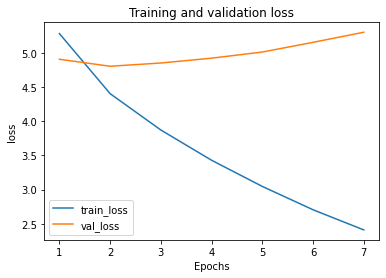

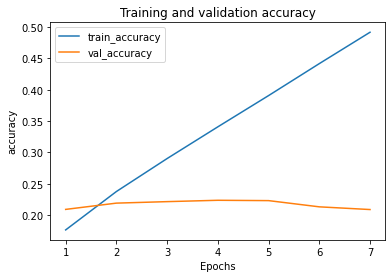

In [18]:
# Train model
parameters = {
    'batch_size' : 128 ,
    'validation_split' : None ,
    'epochs' : 7 ,
    'val_data' :  ([x_val, x_val_midi], y_val)
}
lyrics_generator = LyricsGenerator(embedding_dim, total_words, x_train.shape[1], x_train_midi.shape[1], embedding_matrixs)
h = lyrics_generator.fit([x_train, x_train_midi], y_train, parameters)
lyrics_generator.plot_metric(h)
lyrics_generator.plot_metric(h, metric="accuracy")

In [19]:
df_songs_test = load_songs('/content/drive/MyDrive/DL/Assignment_3/Lyrics/lyrics_test_set.csv')
df_songs_test['filename'] = df_songs_test['artist'].str.replace(' ', "_") + "_-" + df_songs_test['title'].str.replace(' ', "_") + ".mid"
df_test = pd.merge(df_songs_test, df_midi, on="filename")

columns = ['numerator', 'denominator','clocksPerTick', 'demisemiquaverPer24Clocks', 'tempo']
for i, col in enumerate(columns):
  scaled_features = scalers[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index, columns=[col])
  df_test[col] = tmp_df[col]


columns = ['key', 'mode']
for i, col in enumerate(columns):
  scaled_features = onehot_encoders[i].transform(df_test[col].values.reshape(-1, 1))
  tmp_df = pd.DataFrame(scaled_features, index=df_test.index)
  tmp_df.columns = onehot_encoders[i].get_feature_names([col])
  df_test.drop([col] ,axis=1, inplace=True)
  df_test = pd.concat([df_test, tmp_df ], axis=1)

x_test, x_test_midi, y_test = create_x_y(df_test, tokenize, total_words, max_sequence_len)
# x_test_midi = np.asarray(x_test_midi[0]).astype('float32').reshape(1,x_test_midi[0].size)
x_test_midi = np.asarray(x_test_midi).astype('float32')

[[328, 14], [328, 14, 113], [328, 14, 113, 112], [328, 14, 113, 112, 8], [328, 14, 113, 112, 8, 14], [328, 14, 113, 112, 8, 14, 278], [328, 14, 113, 112, 8, 14, 278, 673], [328, 14, 113, 112, 8, 14, 278, 673, 1], [328, 14, 113, 112, 8, 14, 278, 673, 1, 29], [328, 14, 113, 112, 8, 14, 278, 673, 1, 29, 2]]


In [20]:
prediction = lyrics_generator.evaluate([x_test, x_test_midi], y_test)
print(prediction)

39/39 [==============================] - 0s 4ms/step - loss: 4.9675 - accuracy: 0.2534
[4.967465877532959, 0.25340819358825684]


In [26]:
def generate_text(x, eof, model, max_sequence_len, vocab_size):
    seed_text, midi_metadata = x
    next_word = ""
    word_indices = np.arange(vocab_size)# + 1
    word_count = 0
    while next_word != eof:
      token_list = tokenize.texts_to_sequences([seed_text])[0]
      token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
      predicted_proba = model.model.predict_on_batch([token_list, midi_metadata])
      # print(token_list)
      # print(predicted_proba.reshape((predicted_proba.shape[1])).shape)
      # sample the word index acording to predicted proba 
      chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))
      # print(sum(predicted_proba.reshape((predicted_proba.shape[1]))))
      # do not repeat a word if it was in last 5
      while chosen_index in token_list[:5]:
        chosen_index = np.random.choice(word_indices ,1 ,replace=False, p=predicted_proba.reshape((predicted_proba.shape[1])))
      word_count += 1
      next_word = tokenize.sequences_to_texts([chosen_index])[0]
      seed_text += " " + next_word
    print(f'total number of words {word_count}')
    return seed_text

In [29]:
tokenize.texts_to_sequences(['g'])[0]

[3528]

In [28]:
print(generate_text(['forgive me baby because i made a crime', x_test_midi[0].reshape(1,x_test_midi[0].size)], "eof" , lyrics_generator , max_sequence_len, total_words).replace("&","\n"))

total number of words 194
forgive me baby because i made a crime 
 n you come to me and stopped around 
 well theres been at your doorbell and light will my heart 
 you know the way id feel like 
 love will be with you how are i too 
 feeling the thang and charlie takes me g 
 or playing enough for christmas and ill rush home too 
 you showed me in the look where it could be 
 soon they wore heard when she cry 
 his friends dont know how she was 
 good and different so cooly has found too clear 
 and the only one i hear are 
 band knows to pray and she echoes 
 just the two of stars with all mine 
 why are you baby if a man has could help me two 
 i guess its there for me so long 
 you may make it like so much nothing just this shit 
 isnt all my problems it was cold 
 its been running for the palm slim they told you how fine just the first 
 sun came to dance for a new york just the piano man 
 eof
